### Training code for dataset Bla Bla

Training is done in a supervised way. For every input patch, we have the two corresponding target patches using which we train our VSE (Variational Splitting Encoder decoder Network) with KL-divergence loss and a per-channel likelihood loss, following denoiSplit[ref]. In the likelihood computation, Noise models are used. Besides the primary input patch, we also feed LC inputs, originally introduced in uSplit[ref], to the network to make available information about larger spatial context. 

### Important ! 

This step can be skipped! Only run this notebook if you want to train the microsplit model from scratch or finetune. Pretrained model checkpoint is available 
By default this notebook runs example training for 5 epochs. 

#### General imports

In [1]:
import pooch
from pathlib import Path
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader
from careamics.lightning import VAEModule

from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.callbacks import get_callbacks
from microsplit_reproducibility.utils.io import load_checkpoint, load_checkpoint_path
from microsplit_reproducibility.datasets import create_train_val_datasets
from microsplit_reproducibility.utils.utils import (
    plot_training_metrics,
    plot_input_patches,
    plot_training_outputs,
)

#### Experiments specific imports

In [2]:
from microsplit_reproducibility.configs.parameters.HT_LIF24 import (
    get_microsplit_parameters,
)
from microsplit_reproducibility.configs.data.HT_LIF24 import get_data_configs
from microsplit_reproducibility.datasets.HT_LIF24 import get_train_val_data

### Define sub-experiment 

In [3]:
index = "20ms"

### Download the data

In [4]:
DATA = pooch.create(
    path="./data",
    base_url="https://download.fht.org/jug/microsplit/ht_lif24/data",
    registry={"ht_lif24.zip": None},
)

NOISE_MODELS = pooch.create(
    path="./noise_models",
    base_url=f"https://download.fht.org/jug/microsplit/ht_lif24/{index}",
    registry={
        "nm_ht_lif24_ch1_20ms.npz": None,
        "nm_ht_lif24_ch2_20ms.npz": None,
        "nm_ht_lif24_ch3_20ms.npz": None,
    },
)

MODEL_CHECKPOINTS = pooch.create(
    path="./checkpoints",
    base_url=f"https://download.fht.org/jug/microsplit/ht_lif24/{index}",
    registry={"best.ckpt": None, "last.ckpt": None},
)

In [5]:
for i, f in enumerate(NOISE_MODELS.registry):
    NOISE_MODELS.fetch(f"nm_ht_lif24_ch{i+1}_{index}.npz")

DATA.fetch("ht_lif24.zip", processor=pooch.Unzip())

for f in MODEL_CHECKPOINTS.registry:
    MODEL_CHECKPOINTS.fetch(f"{f}")

### Get data and experiment parameters

In [6]:
train_data_config, val_data_config, test_data_configs = get_data_configs(
    dset_type=index
)
experiment_params = get_microsplit_parameters(
    dset_type=index, nm_path=NOISE_MODELS.path
)

In [7]:
for k in train_data_config:
    print(k)

('data_type', <DataType.NicolaData: 1>)
('depth3D', 1)
('datasplit_type', <DataSplitType.Train: 1>)
('num_channels', 4)
('ch1_fname', None)
('ch2_fname', None)
('ch_input_fname', None)
('input_is_sum', False)
('input_idx', 3)
('target_idx_list', [0, 1, 2])
('start_alpha', None)
('end_alpha', None)
('image_size', (64, 64))
('grid_size', 32)
('empty_patch_replacement_enabled', False)
('empty_patch_replacement_channel_idx', None)
('empty_patch_replacement_probab', None)
('empty_patch_max_val_threshold', None)
('uncorrelated_channels', False)
('uncorrelated_channel_probab', 0.5)
('poisson_noise_factor', -1.0)
('synthetic_gaussian_scale', 100.0)
('input_has_dependant_noise', True)
('enable_gaussian_noise', False)
('allow_generation', False)
('training_validtarget_fraction', None)
('deterministic_grid', None)
('enable_rotation_aug', False)
('max_val', None)
('overlapping_padding_kwargs', {'mode': 'reflect'})
('print_vars', False)
('normalized_input', True)
('use_one_mu_std', True)
('train_au

In [8]:
experiment_params

{'algorithm': 'denoisplit',
 'loss_type': 'denoisplit_musplit',
 'img_size': (64, 64),
 'target_channels': 3,
 'multiscale_count': 3,
 'predict_logvar': 'pixelwise',
 'nm_paths': ['noise_models/nm_ht_lif24_ch1_20ms.npz',
  'noise_models/nm_ht_lif24_ch2_20ms.npz',
  'noise_models/nm_ht_lif24_ch3_20ms.npz'],
 'kl_type': 'kl_restricted',
 'batch_size': 32,
 'lr': 0.001,
 'lr_scheduler_patience': 30,
 'earlystop_patience': 200,
 'num_epochs': 400,
 'num_workers': 0,
 'mmse_count': 10,
 'grid_size': 32}

### Create dataset

In [16]:
train_dset, val_dset, _, data_stats = create_train_val_datasets(
    datapath=DATA.path / "ht_lif24.zip.unzip/ht_lif24",
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=val_data_config,
    load_data_func=get_train_val_data,
)

Loading from data/ht_lif24.zip.unzip/ht_lif24/Set1/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set2/uSplit_20ms.nd2
ND2 dimensions: {'P': 11, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set3/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set4/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set5/uSplit_20ms.nd2
ND2 dimensions: {'P': 21, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set6/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; 

### Create dataloaders

In [10]:
train_dloader = DataLoader(
    train_dset,
    batch_size=experiment_params["batch_size"],
    num_workers=experiment_params["num_workers"],
    shuffle=True,
)
val_dloader = DataLoader(
    val_dset,
    batch_size=experiment_params["batch_size"],
    num_workers=experiment_params["num_workers"],
    shuffle=False,
)

### Get experiment configs

In [11]:
experiment_params["data_stats"] = data_stats  # TODO rethink

loss_config = get_loss_config(**experiment_params)
model_config = get_model_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)
training_config = get_training_config(**experiment_params)
lr_scheduler_config = get_lr_scheduler_config(**experiment_params)
optimizer_config = get_optimizer_config(**experiment_params)

experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
    lr_scheduler_config=lr_scheduler_config,
    optimizer_config=optimizer_config,
)

/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


### Initialize the model

In [12]:
model = VAEModule(algorithm_config=experiment_config)

[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[MultiChannelNoiseModel] Nmodels count:3
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0


### Load checkpoint (optional)

It's possible to load a checkpoint to continue training

In [13]:
ckpt_path = load_checkpoint_path("checkpoints", best=True)
model = VAEModule.load_from_checkpoint(
    ckpt_path, algorithm_config=experiment_config
)

[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[MultiChannelNoiseModel] Nmodels count:3
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0


### Visualize input data


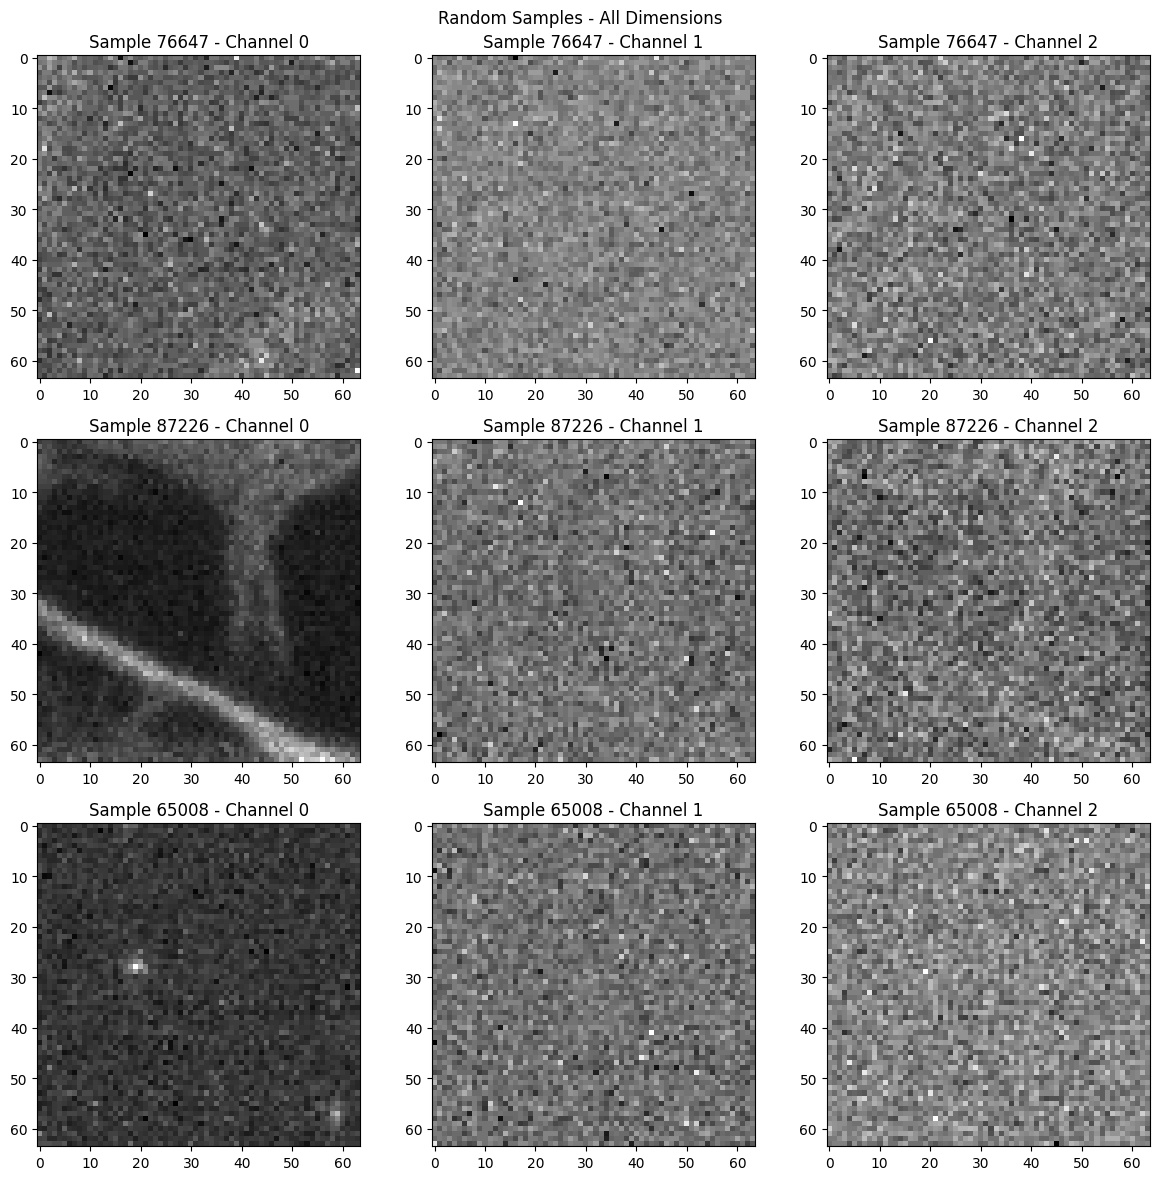

In [14]:
plot_input_patches(dataset=train_dset, num_channels=3, num_samples=3)

### Train the model

Only 5 epochs for the sake of the example

In [15]:
trainer = Trainer(
    max_epochs=training_config.num_epochs,
    accelerator="gpu",
    enable_progress_bar=True,
    callbacks=get_callbacks("/checkpoints"),
    precision=training_config.precision,
    gradient_clip_val=training_config.gradient_clip_val,
    gradient_clip_algorithm=training_config.gradient_clip_algorithm,
)
trainer.fit(
    model=model,
    train_dataloaders=train_dloader,
    val_dataloaders=val_dloader,
)

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/ashesh.ashesh/mambaforge/envs/microSplit/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

### Training logs

In [ ]:
plot_training_metrics(list(Path("csv_logs").rglob("metrics.csv"))[0])

In [ ]:
plot_training_outputs(val_dset, trainer.model, num_channels=3)